In [9]:
import json
import re
from collections import Counter
from statistics import mean
from textstat import flesch_kincaid_grade
from tqdm import tqdm
import matplotlib.pyplot as plt

def read_jsonl_file(file_path):
    with open(file_path, 'r') as file:
        stories = [json.loads(line) for line in file]
    return stories

def analyze_story(story):
    num_characters = len(story)
    
    words = re.findall(r'\b\w+\b', story)
    num_words = len(words)
    
    sentences = re.split(r'[.!?]', story)
    num_sentences = len([s for s in sentences if s.strip()])
    
    paragraphs = story.split('\n\n')
    num_paragraphs = len(paragraphs)
    
    # Calculate average paragraph length (in words)
    avg_paragraph_length = num_words / num_paragraphs if num_paragraphs > 0 else 0
    
    # Calculate word frequency distribution
    word_freq = Counter(words)
    
    reading_level = flesch_kincaid_grade(story)
    
    return {
        'num_characters': num_characters,
        'num_words': num_words,
        'num_sentences': num_sentences,
        'num_paragraphs': num_paragraphs,
        'avg_paragraph_length': avg_paragraph_length,
        'word_freq': word_freq,
        'reading_level': reading_level
    }

# Compute Metrics for All Stories and Summarize
def compute_metrics(stories):
    all_metrics = []
    for story_data in tqdm(stories, "Analyzing stories"):
        story_metrics = analyze_story(story_data['story'])
        story_metrics['id'] = story_data['generation_id']
        story_metrics['expected_num_paragraphs'] = story_data['num_paragraphs']
        all_metrics.append(story_metrics)
    
    # Calculate overall averages
    avg_num_words = mean([m['num_words'] for m in all_metrics])
    avg_reading_level = mean([m['reading_level'] for m in all_metrics])
    avg_num_sentences = mean([m['num_sentences'] for m in all_metrics])
    avg_num_characters = mean([m['num_characters'] for m in all_metrics])

    print(f"Average number of words: {avg_num_words}")
    print(f"Average reading level: {avg_reading_level}")
    print(f"Average number of sentences: {avg_num_sentences}")
    print(f"Average number of characters: {avg_num_characters}")

    
    return all_metrics

# Visualize Word Distribution
def plot_word_distribution(metrics):
    all_words = Counter()
    for m in metrics:
        all_words.update(m['word_freq'])
    
    topk = 42
    most_common_words = all_words.most_common(topk)
    words, frequencies = zip(*most_common_words)
    
    plt.figure(figsize=(16, 4))
    plt.bar(words, frequencies)
    plt.xticks(rotation=45)
    plt.title(f"Top {topk} Most Common Words")
    plt.show()

# Plot Histogram of Story Length and Paragraphs vs Story Length
def plot_story_length_histogram(metrics):
    story_lengths = [m['num_words'] for m in metrics]
    
    plt.figure(figsize=(10, 6))
    plt.hist(story_lengths, bins=10, edgecolor='black')
    plt.title("Histogram of Story Lengths (in Words)")
    plt.xlabel("Story Length (words)")
    plt.ylabel("Frequency")
    plt.show()

def plot_paragraphs_vs_story_length(metrics):
    num_paragraphs = [m['expected_num_paragraphs'] for m in metrics]
    story_lengths = [m['num_words'] for m in metrics]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(story_lengths, num_paragraphs)
    plt.title("Number of Paragraphs vs. Story Length")
    plt.xlabel("Story Length (words)")
    plt.ylabel("Expected Number of Paragraphs")
    plt.show()

file_path = r'data\batches_2024-09-03-11-24-05\processed.jsonl'
stories = read_jsonl_file(file_path)
metrics = compute_metrics(stories)
plot_word_distribution(metrics)
plot_story_length_histogram(metrics)
plot_paragraphs_vs_story_length(metrics)

Analyzing stories:   4%|▍         | 32665/781382 [00:08<03:21, 3718.69it/s]


KeyboardInterrupt: 

600000it [00:14, 42222.17it/s]
65000it [00:01, 37804.50it/s]
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Fraction of stories with [UNK] tokens: 0.0
Average number of [UNK] tokens: nan


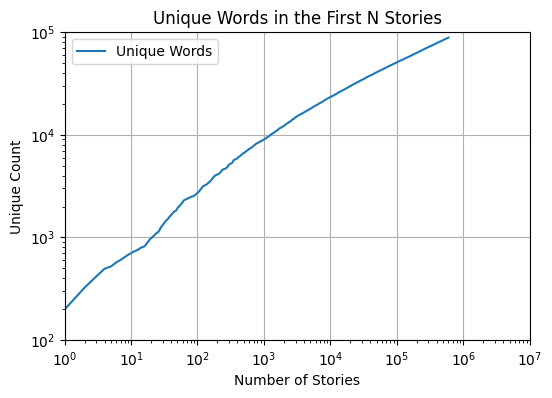

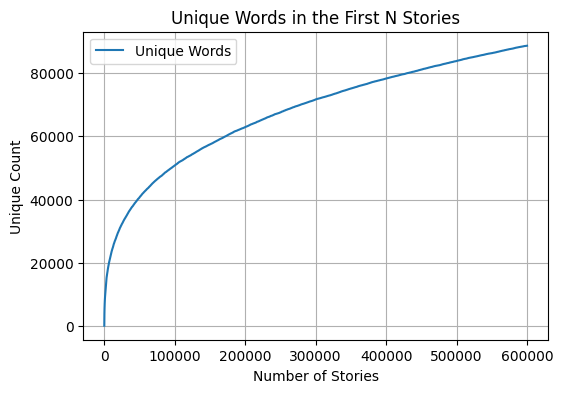

In [11]:
import json
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from make_hf_tokenizer import make_tokenizer
import numpy as np

def plot_unique_words_and_tokens(jsonl_filepath, n):
    unique_words = []
    unique_tokens = []
    word_counts = Counter()
    token_counts = Counter()
    
    tokenizer = make_tokenizer(["vocab/ch-hf.txt", "vocab/wordbank-en.txt"])

    unk_counter = []
    with open(jsonl_filepath, 'r') as file:
        for i, line in tqdm(enumerate(file)):
            if i < 65000:
                continue
            if i >= n:
                break
            data = json.loads(line)
            story = data['story']
            
            words = story.split()
            word_counts.update(words)
            """tokens = tokenizer.encode(story).tokens
            # counting number of unk
            unk_counter.append(tokens.count('[UNK]'))
            token_counts.update(tokens)"""
            
            unique_words.append(len(word_counts))
            unique_tokens.append(len(token_counts))
    with open(jsonl_filepath, 'r') as file:
        for i, line in tqdm(enumerate(file)):
            if i >= 65000:
                break
            data = json.loads(line)
            story = data['story']
            
            words = story.split()
            word_counts.update(words)
            """tokens = tokenizer.encode(story).tokens
            # counting number of unk
            unk_counter.append(tokens.count('[UNK]'))
            token_counts.update(tokens)"""
            
            unique_words.append(len(word_counts))
            unique_tokens.append(len(token_counts))

    print(f"Fraction of stories with [UNK] tokens: {sum(np.array(unk_counter) > 0)/n}")
    print(f"Average number of [UNK] tokens: {np.mean(unk_counter)}")
    # Plot the results
    for log in [True, False]:
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, n + 1), unique_words, label='Unique Words')
        #plt.plot(range(1, n + 1), unique_tokens, label='Unique Custom Tokenizer Tokens')
        plt.xlabel('Number of Stories')
        plt.ylabel('Unique Count')
        if log:
            plt.xscale('log')
            plt.yscale('log')
            plt.xlim(1, 10**7)
            plt.ylim(100,10**5)
        plt.title('Unique Words in the First N Stories')
        plt.legend()
        plt.grid(True)
        plt.show()

n = 600000
plot_unique_words_and_tokens(file_path, n)
